# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

Extraction complete.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


Min:  tensor(-0.9843)
Max:  tensor(0.7647)


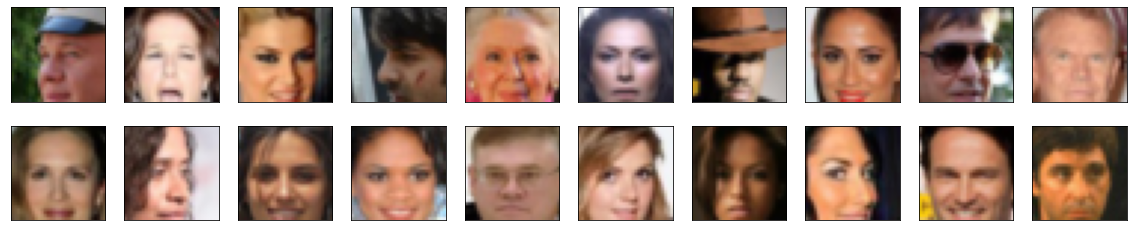

In [1]:
import zipfile

# Path to the ZIP file
zip_path = 'processed-celeba-small.zip'

# Extract the ZIP file in the current directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

print("Extraction complete.")


data_dir = 'processed-celeba-small.zip'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
#import helper

%matplotlib inline

# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    train_set = datasets.ImageFolder(data_dir, transform= transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)
    return train_loader

# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    return x * (feature_range[1] - feature_range[0]) + feature_range[0]
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Helper function to create a convolutional layer, with optional batch normalization."""
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        """Initialize the Discriminator Module."""
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.c1 = conv(3, conv_dim, batch_norm=False)
        self.c2 = conv(conv_dim, conv_dim*2, batch_norm=True)
        self.c3 = conv(conv_dim*2, conv_dim*4, batch_norm=True)

        # Adding an intermediate fully connected layer
        self.fc1 = nn.Linear(conv_dim*4*4*4, 1024)
        self.fc_bn1 = nn.BatchNorm1d(1024)  # Batch norm after fully connected layer
        self.fc2 = nn.Linear(1024, 1)  # Final output layer
        self.dropout = nn.Dropout(0.3)  # Dropout layer to prevent overfitting

    def forward(self, x):
        """Forward propagation of the neural network."""
        x = F.leaky_relu(self.c1(x), negative_slope=0.2)
        x = F.leaky_relu(self.c2(x), negative_slope=0.2)
        x = F.leaky_relu(self.c3(x), negative_slope=0.2)
        x = x.view(-1, self.conv_dim*4*4*4)
        
        x = F.leaky_relu(self.fc_bn1(self.fc1(x)), negative_slope=0.2)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Helper function to create a transposed-convolutional layer, with optional batch normalization."""
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
     
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self, z_size, conv_dim):
        """Initialize the Generator Module."""
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.fc1 = nn.Linear(z_size, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)  # Batch norm after fully connected layer
        self.fc2 = nn.Linear(2048, conv_dim*4*4*4)

        self.tc1 = deconv(conv_dim*4, conv_dim*2)
        self.tc2 = deconv(conv_dim*2, conv_dim)
        self.tc3 = deconv(conv_dim, 3, batch_norm=False)

    def forward(self, x):
        """Forward propagation of the neural network."""
        x = F.leaky_relu(self.fc_bn1(self.fc1(x)), negative_slope=0.2)
        x = self.fc2(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        x = F.leaky_relu(self.tc1(x), negative_slope=0.2)
        x = F.leaky_relu(self.tc2(x), negative_slope=0.2)
        x = torch.tanh(self.tc3(x))
        return x

def weights_init_normal(m):
    """Applies initial weights to certain layers in a model."""
    classname = m.__class__.__name__

    if classname in ['Conv2d', 'ConvTranspose2d', 'Linear']:
        torch.nn.init.normal_(m.weight, mean=0, std=0.02)

def build_network(d_conv_dim, g_conv_dim, z_size):
    # Define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size

                  
, conv_dim=g_conv_dim)

    # Initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

# Define model hyperparams
d_conv_dim = 128 
g_conv_dim = 128
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)



Discriminator(
  (c1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (c2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=8192, out_features=1024, bias=True)
  (fc_bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=2048, bias=True)
  (fc_bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, o

In [3]:
# Test the Discriminator and Generator
def test_discriminator(D, image_size=32):
    """Tests the Discriminator to ensure correct output shape."""
    batch_size = 16
    x = torch.randn(batch_size, 3, image_size, image_size)  # Random batch of images
    output = D(x)
    assert output.shape == (batch_size, 1), f"Expected output shape (16, 1), got {output.shape}"
    print(f"Discriminator test passed. Output shape: {output.shape}")

def test_generator(G, z_size):
    """Tests the Generator to ensure correct output shape."""
    batch_size = 16
    z = torch.randn(batch_size, z_size)  # Random batch of noise vectors
    output = G(z)
    assert output.shape == (batch_size, 3, 32, 32), f"Expected output shape (16, 3, 32, 32), got {output.shape}"
    print(f"Generator test passed. Output shape: {output.shape}")

# Run tests
test_discriminator(D, image_size=32)
test_generator(G, z_size)
    
    
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')  
    
    


Discriminator test passed. Output shape: torch.Size([16, 1])
Generator test passed. Output shape: torch.Size([16, 3, 32, 32])
Training on GPU!


## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

In [4]:
# Training function 
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Define loss functions and optimizers
    real_loss = nn.BCEWithLogitsLoss()
    fake_loss = nn.BCEWithLogitsLoss()
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Epoch training loop
    for epoch in range(n_epochs):
        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, torch.ones_like(D_real))

            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake, torch.zeros_like(D_fake))
            
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake, torch.ones_like(D_fake))
            
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        # After each epoch, generate and save sample, fake images
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

# Example training call
n_epochs = 8
losses = train(D, G, n_epochs)

Epoch [    1/    8] | d_loss: 1.5203 | g_loss: 0.5402
Epoch [    1/    8] | d_loss: 1.3535 | g_loss: 0.7522
Epoch [    1/    8] | d_loss: 1.2077 | g_loss: 0.9215
Epoch [    1/    8] | d_loss: 1.0968 | g_loss: 1.1046
Epoch [    1/    8] | d_loss: 1.1298 | g_loss: 1.2425
Epoch [    1/    8] | d_loss: 1.2394 | g_loss: 0.7896
Epoch [    1/    8] | d_loss: 1.2115 | g_loss: 0.8047
Epoch [    1/    8] | d_loss: 1.2833 | g_loss: 0.9539
Epoch [    1/    8] | d_loss: 1.2353 | g_loss: 0.9846
Epoch [    1/    8] | d_loss: 1.1805 | g_loss: 1.0549
Epoch [    1/    8] | d_loss: 1.3848 | g_loss: 1.0203
Epoch [    1/    8] | d_loss: 1.3020 | g_loss: 0.9355
Epoch [    1/    8] | d_loss: 1.1535 | g_loss: 0.9551
Epoch [    1/    8] | d_loss: 1.3236 | g_loss: 0.9224
Epoch [    1/    8] | d_loss: 1.1540 | g_loss: 0.9729
Epoch [    1/    8] | d_loss: 1.2382 | g_loss: 0.9366
Epoch [    1/    8] | d_loss: 1.4708 | g_loss: 1.0187
Epoch [    1/    8] | d_loss: 1.3602 | g_loss: 0.9502
Epoch [    1/    8] | d_loss

### Training losses

Plot the training losses for the generator and discriminator.

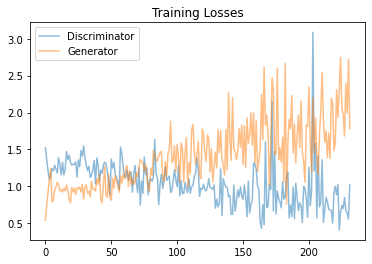

In [5]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

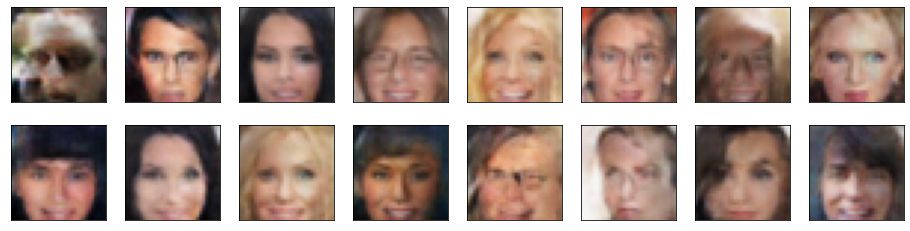

In [6]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    

_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

In [ ]:
# I change epoche from 5 to 8, there's no major improvement. 
# Discriminator traning loss seemed to be improved a tiny bit 
# (from roughly around value of 1 to 0.5) 
# but the generator loss seems to went from around 2 to reaching 3. 